# EXERCISE 09 - Transient universe

Time-domain astronomy is one of the new frontiers. Example of transient phenomena include:

- Tidal distruption events. [Stars shouldn't go near supermassive black holes, it's dangerous!]

- Sudden flares of active galactic nuclei

- Supernovae.

## MODULES IMPORT

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from IPython.display import display, Math

import emcee
import corner

# L12
import dynesty
from dynesty import plotting as dyplot
from dynesty.utils import resample_equal

# L11:

## Tasks

**Remember this is a real research example, not an exam! You're welcome (and encouraged actually!) to use all the tutorials/answers/hack you find online!**

1. Read in solutions/transient.npy. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2. One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

    $y = b$ , for $t < t_{0}$

    $y = b + A\exp[-\alpha(t - t_{0})]$, for $t \geq t_{0}$

    where $b$ is the background amplitude, $A$ is the burst amplitude, $t_{0}$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

    Code this burst model, and code a likelihood function for this data with the burst model. Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now is time, and the polynomial model is now the burst model.

3. Using one of the MCMC sampler that we looked at in class (emcee, pymc), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of ${b, A, t_{0}, \alpha}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b \in \mathrm{Uniform}[0, 50]$, $A \in \mathrm{Uniform}[0, 50]$ , $t_{0} \in \mathrm{Uniform}[0, 100]$
, and $\ln\alpha \in \mathrm{Uniform}[-5, 5]$ (careful: uniform in $\ln\alpha$, not $\alpha$).

4. Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5. Make a corner plot of the 4-D parameter space, with labels, $[68, 95] \%$ credible levels and quantiles, and titles.

6. Now choose 100 samples randomly from your burned, thinned chain and plot the corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these 100 burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7. For each parameter, find the median and $90\%$ credible region of the marginalized distribution and quote results as, for instance, $t_{0} = X_{-Z}^{+Y}$

# 1 - PLOT THE DATA

Task 1

In [2]:
data = np.load('transient.npy')

time, flux, errf = data[:, 0], data[:, 1], data[:, 2]

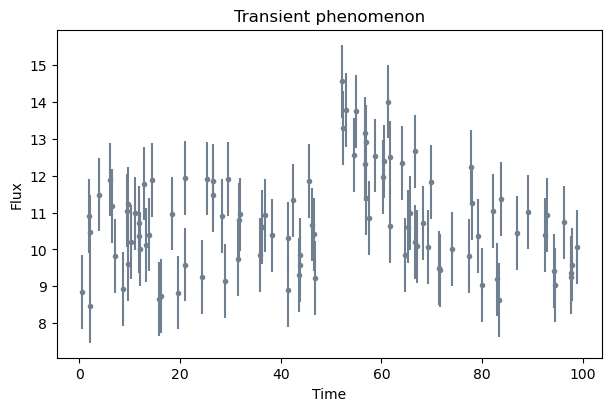

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')

ax.errorbar(time, flux, errf, fmt='.', c='slategray')

ax.set_title('Transient phenomenon')
ax.set_xlabel('Time')
ax.set_ylabel('Flux');

# 2 - BUILD THE MODEL (mcmc)

Tasks from 2 to 5, and 7

In [4]:
## --- BRUST MODEL --- ##

def burst_model(par, t):
    b, A, t_0, alpha = par
    
    out = A * np.exp(-alpha * (t - t_0))
    out[t < t_0] = 0
    return out + b

In [5]:
# NOTE: emcee wants log(probatility) and function in the form f(parameters_array, variables)

def log_Likelihood(par, t, flux_obs, flux_err):
    flux_exp = burst_model(par, t)

    out = np.log(2 * np.pi * flux_err**2) + (flux_exp - flux_obs)**2 / flux_err**2
    return -.5 * np.sum(out)

def log_Prior(par):
    b, A, t_0, alpha = par
    
    if b < 0 or b > 50 or A < 0 or A > 50 or t_0 < 0 or t_0 > 100 or alpha < 1e-5 or alpha > 1e5: 
        return -np.inf
    else:
        return -np.log(50 * 50 * 100 * np.log(1e5/1e-5) * alpha) 


def log_Posterior(params, t, flux_obs, flux_err):
    logPrior = log_Prior(params)
    
    if np.isfinite(logPrior):
        return logPrior + log_Likelihood(params, t, flux_obs, flux_err)
    else:
        return logPrior

In [24]:
## --- SAMPLER --- ##

ndim = 4  # number of parameters in the burst_model
nwalkers = 20  # number of MCMC walkers
nsteps = 10000  # number of MCMC steps to take **for each walker**

# initialize theta
starting_guesses = np.array([10, 5, 50, 1e-1]) + norm.rvs(scale=1e-2, size=(nwalkers, ndim))
#starting_guesses = np.array([1, 50, 5, 1]) + norm.rvs(scale=1e-2, size=(nwalkers, ndim))

# the function call where all the work happens:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_Posterior, args=[time, flux, errf])
sampler.run_mcmc(starting_guesses, nsteps);

print('Done')

Done


## TRACE PLOTS

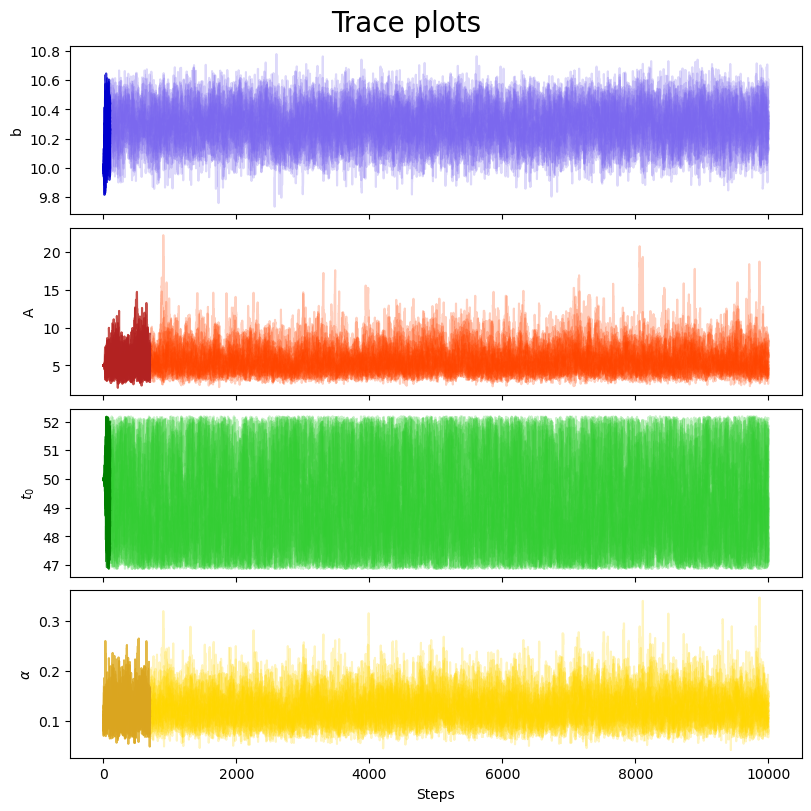

In [25]:
## --- TRACE PLOTS --- ##

samples = sampler.get_chain() # sampler.chain is of shape (nwalkers, nsteps, ndim)

fig, axs = plt.subplots(4, 1, figsize=(8, 8), sharex=True, layout='constrained')
fig.suptitle('Trace plots', fontsize=20)

steps = np.arange(nsteps) + 1
label = ['b', 'A', r'$t_{0}$', r'$\alpha$']
color = [['mediumslateblue', 'mediumblue'], ['orangered', 'firebrick'], ['limegreen', 'green'], ['gold', 'goldenrod']]

burn = [100, 700, 100, 700]

for i, ax in enumerate(axs):
    ax.plot(steps, samples[:, :, i], c=color[i][0], alpha=.25)
    ax.plot(steps[:burn[i]], samples[:burn[i], :, i], c=color[i][1], alpha=.75, label='burn-in')

    ax.set_ylabel(label[i])

axs[-1].set_xlabel('Steps');

## CORNER PLOTS

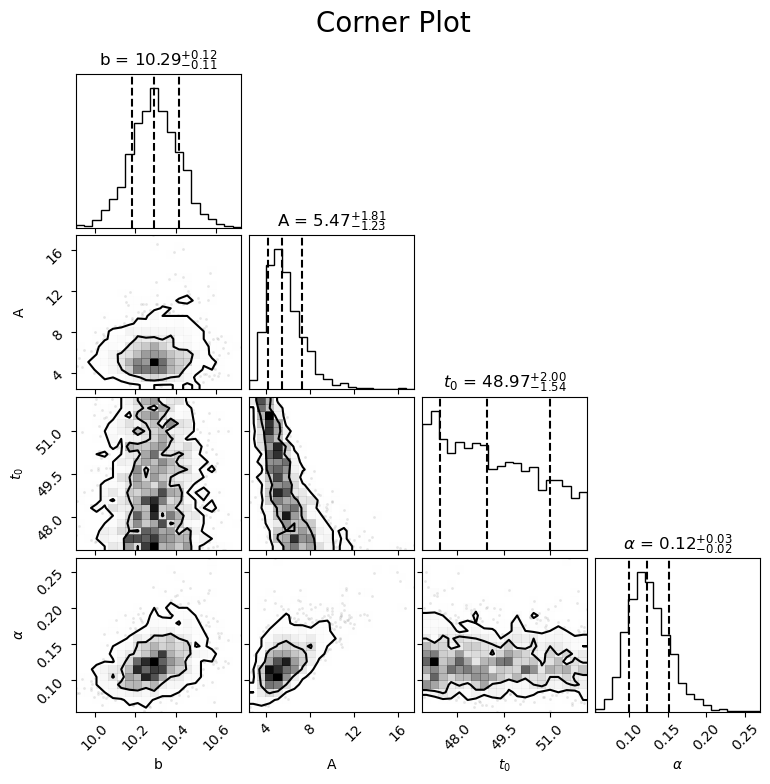

In [8]:
## --- CORNER PLOTS --- ##

taus = sampler.get_autocorr_time()
burn = np.max(burn)
thin = int(np.max(taus)) + 1

emcee_traces = sampler.get_chain(discard=burn, thin=thin, flat=True)
fig = corner.corner(emcee_traces, labels=label, show_titles=True, title_args={"fontsize": 12}, 
                    quantiles=[0.16, 0.5, 0.84], 
                    levels=[0.682, 0.95])
                    #range = [(9,11),(0,22),(45,55),(0.05,0.3)])
                  
fig.suptitle("Corner Plot", fontsize = 20)
fig.set_size_inches(8, 8)

plt.subplots_adjust(top=0.90);

In [9]:
label = ['b', 'A', 't_{0}', r'\alpha']

for i, l in enumerate(label):
    mcmc = np.percentile(emcee_traces[:, i], [5, 50, 95])  # median is 50 percentile
    
    q = np.diff(mcmc)

    txt = "\mathrm{{{3}}} = {0:.2f}_{{-{1:.2f}}}^{{{2:.2f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], l)

    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# 3 - TEST THE MODEL

Task 6

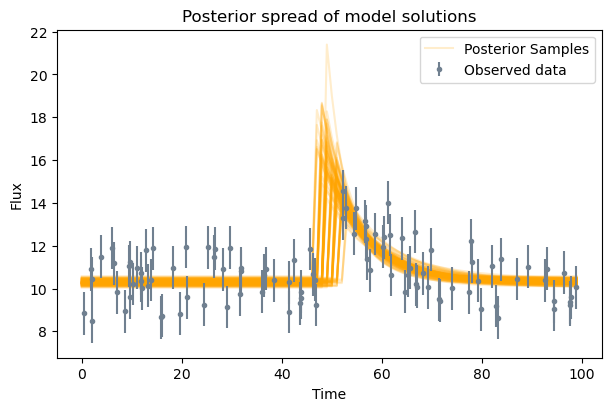

In [10]:
t = np.arange(100)

index = np.random.choice(len(emcee_traces), size=100, replace=False)
random_samples = emcee_traces[index]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')

for i, par in enumerate(random_samples):
    y = burst_model(par, t)
    l = "Posterior Samples" if i == 0 else None
    ax.plot(t, y, color='orange', alpha=.2, label=l)

ax.errorbar(time, flux, errf, fmt = ".", c='slategray', label="Observed data")

ax.set_title("Posterior spread of model solutions")
ax.set_xlabel("Time")
ax.set_ylabel("Flux")

ax.legend();

# L12:

## Tasks

Let's go back to our previous example on the astrophysical transient.

8. Fit the same model from before with the same priors, but this time use nested sampling.

    $y = b$ , for $t < t_{0}$

    $y = b + A\exp[-\alpha(t - t_{0})]$, for $t \geq t_{0}$

    Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used ppf from scipy.stats.uniform, but there are other ways to do it)

    An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

9. Another possible model that may explain the data is a Gaussian profile described by:
  
    $y = b + A\exp[-(t - t_{0})^2 / 2\sigma_W^2]$

    Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

10. Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data? Express this in terms of the Jeffrey's scale.

# 4 - BUILD THE MODEL (nested sampling)

Task 8

In [11]:
def prior_transform(u):
    u[0:2] *= 50
    u[2] *= 100
    u[3] = np.exp(10 * u[3] - 5)

    return u

# NOTE: dynesty wants log(likelihood(parameters)) and doesn't allow to specify the data as additional input

def log_L_dynesty(par):
    flux_exp = burst_model(par, time)

    out = np.log(2 * np.pi * errf**2) + (flux_exp - flux)**2 / errf**2
    return -.5 * np.sum(out)

In [12]:
## --- SAMPLER --- ##

print(' --- Static Sampling Inizialized ---\n')
print('Sampling ...\t')

sampler = dynesty.NestedSampler(log_L_dynesty, prior_transform, ndim, nlive=1000, bootstrap=0)
sampler.run_nested()

sresults = sampler.results

print('Done\n\n')

logZ_burst = sresults.logz[-1]        # value of logZ
logZerr_burst = sresults.logzerr[-1]  # estimate of the statistical uncertainty on logZ

# NOTE: dynesty refers to the evidence as Z

print(' --- Results ---\n')
print(f'Marginalised evidence = {logZ_burst:.3} ± {logZerr_burst:.3}')

/tmp/ipykernel_4881/1144633182.py:6: RuntimeWarning: overflow encountered in exp
  out = A * np.exp(-alpha * (t - t_0))
/tmp/ipykernel_4881/1144633182.py:6: RuntimeWarning: overflow encountered in multiply
  out = A * np.exp(-alpha * (t - t_0))


 --- Static Sampling Inizialized ---

Sampling ...	


/tmp/ipykernel_4881/1144633182.py:6: RuntimeWarning: overflow encountered in exploglstar:   -inf < -294.278 <    inf | logz: -302.474 +/-  0.086 | dlogz: 140.956 >  1.009]   
  out = A * np.exp(-alpha * (t - t_0))
/tmp/ipykernel_4881/1144633182.py:6: RuntimeWarning: overflow encountered in multiplyar:   -inf < -265.501 <    inf | logz: -273.776 +/-  0.087 | dlogz: 112.080 >  1.009] 
  out = A * np.exp(-alpha * (t - t_0))
/tmp/ipykernel_4881/1144633182.py:6: RuntimeWarning: overflow encountered in exploglstar:   -inf < -230.992 <    inf | logz: -239.420 +/-  0.085 | dlogz: 84.290 >  1.009]
  out = A * np.exp(-alpha * (t - t_0))
/tmp/ipykernel_4881/1144633182.py:6: RuntimeWarning: overflow encountered in multiply
  out = A * np.exp(-alpha * (t - t_0))
/tmp/ipykernel_4881/1144633182.py:6: RuntimeWarning: overflow encountered in expoglstar:   -inf < -217.203 <    inf | logz: -225.382 +/-  0.085 | dlogz: 70.022 >  1.009] 
  out = A * np.exp(-alpha * (t - t_0))
/tmp/ipykernel_4881/1144633182

Done


 --- Results ---

Marginalised evidence = -1.55e+02 ± 0.284


## RUN PLOT

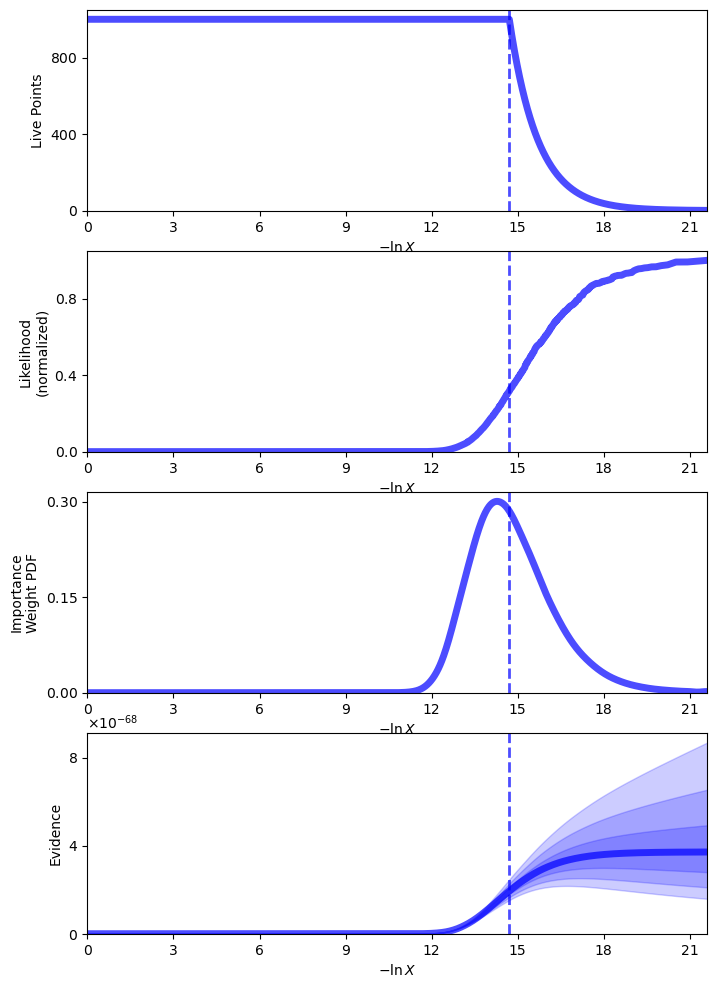

In [13]:
rfig, raxes = dyplot.runplot(sresults)

rfig.set_size_inches(8, 12)

## TRACE PLOTS

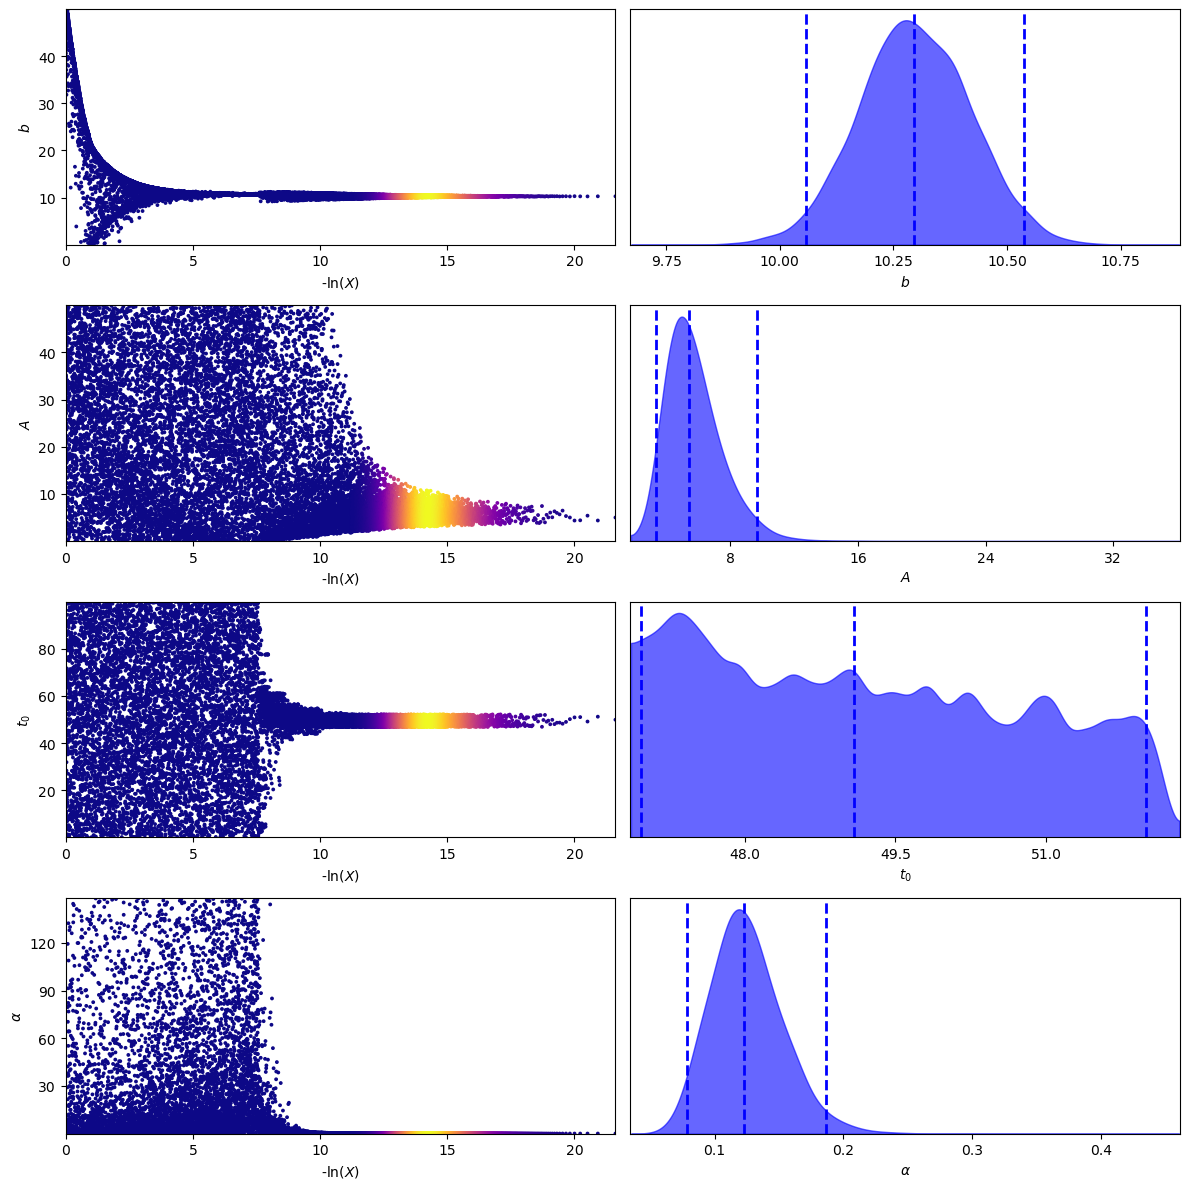

In [14]:
tfig, taxes = dyplot.traceplot(sresults)

taxes[0][0].set_xlabel("-$\\ln(X)$")
taxes[0][0].set_ylabel("$b$")
taxes[0][1].set_xlabel("$b$")


taxes[1][0].set_xlabel("-$\\ln(X)$")
taxes[1][0].set_ylabel("$A$")
taxes[1][1].set_xlabel("$A$")


taxes[2][0].set_xlabel("-$\\ln(X)$")
taxes[2][0].set_ylabel("$t_0$")
taxes[2][1].set_xlabel("$t_0$")

taxes[3][0].set_xlabel("-$\\ln(X)$")
taxes[3][0].set_ylabel(r"$\alpha$")
taxes[3][1].set_xlabel(r"$\alpha$")


tfig.tight_layout();

## CORNER PLOT

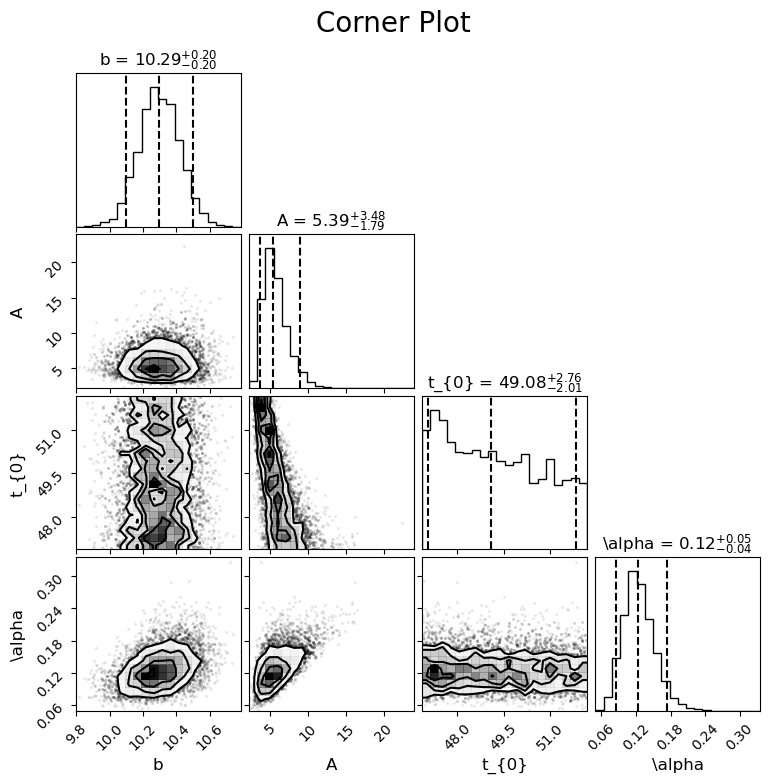

In [15]:
weights = np.exp(sresults['logwt'] - sresults['logz'][-1])
burst_samples = resample_equal(sresults.samples, weights)

fig = corner.corner(burst_samples, labels=label, show_titles=True, title_kwargs={"fontsize": 12}, label_kwargs=dict(fontsize=12), 
                    quantiles=[0.05, 0.50, 0.95])

fig.suptitle("Corner Plot", fontsize = 20)
fig.set_size_inches(8, 8)

plt.subplots_adjust(top=0.90);

In [16]:
for i, l in enumerate(label):
    mcmc = np.percentile(burst_samples[:, i], [5, 50, 95])  # median is 50 percentile
    
    q = np.diff(mcmc)

    txt = "\mathrm{{{3}}} = {0:.2f}_{{-{1:.2f}}}^{{{2:.2f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], l)

    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# 5 - GAUSSIAN MODEL

Tasks 9 and 10

In [17]:
## --- GAUSSIAN MODEL --- ##

def gauss_model(par, t):
    b, A, t_0, sigmaW = par
    
    out = A * np.exp(-(t - t_0)**2 / 2 / sigmaW**2)
    return out + b

# Prior transform
def pt_gauss(u):
    u[0:2] *= 50
    u[2] *= 100
    u[3] = np.exp(8 * u[3] - 4)

    return u


# NOTE: dynesty wants log(likelihood(parameters)) and doesn't allow to specify the data as additional input

def logL_gauss_dynesty(par):
    flux_exp = gauss_model(par, time)

    out = np.log(2 * np.pi * errf**2) + (flux_exp - flux)**2 / errf**2
    return -.5 * np.sum(out)

In [18]:
## --- SAMPLER --- ##

print(' --- Static Sampling Inizialized ---\n')
print('Sampling ...\t')

sampler_gauss = dynesty.NestedSampler(logL_gauss_dynesty, pt_gauss, ndim, nlive=1000, bootstrap=0)
sampler_gauss.run_nested()

sresults = sampler_gauss.results

print('Done\n\n')

logZ_gauss = sresults.logz[-1]        # value of logZ
logZerr_gauss = sresults.logzerr[-1]  # estimate of the statistical uncertainty on logZ

# NOTE: dynesty refers to the evidence as Z

print(' --- Results ---\n')
print(f'Marginalised evidence = {logZ_gauss:.3} ± {logZerr_gauss:.3}')

 --- Static Sampling Inizialized ---

Sampling ...	


16103it [00:11, 1452.95it/s, +1000 | bound: 48 | nc: 1 | ncall: 108935 | eff(%): 15.846 | loglstar:   -inf < -144.338 <    inf | logz: -160.452 +/-  0.136 | dlogz:  0.001 >  1.009]

Done


 --- Results ---

Marginalised evidence = -1.6e+02 ± 0.297


In [20]:
weights = np.exp(sresults['logwt'] - sresults['logz'][-1])
gauss_samples = resample_equal(sresults.samples, weights)

for i, l in enumerate(['b', 'A', 't_0', r'\sigma_W']):
    mcmc = np.percentile(gauss_samples[:, i], [5, 50, 95])  # median is 50 percentile
    
    q = np.diff(mcmc)

    txt = "\mathrm{{{3}}} = {0:.2f}_{{-{1:.2f}}}^{{{2:.2f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], l)

    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## MODELS COMPARISON

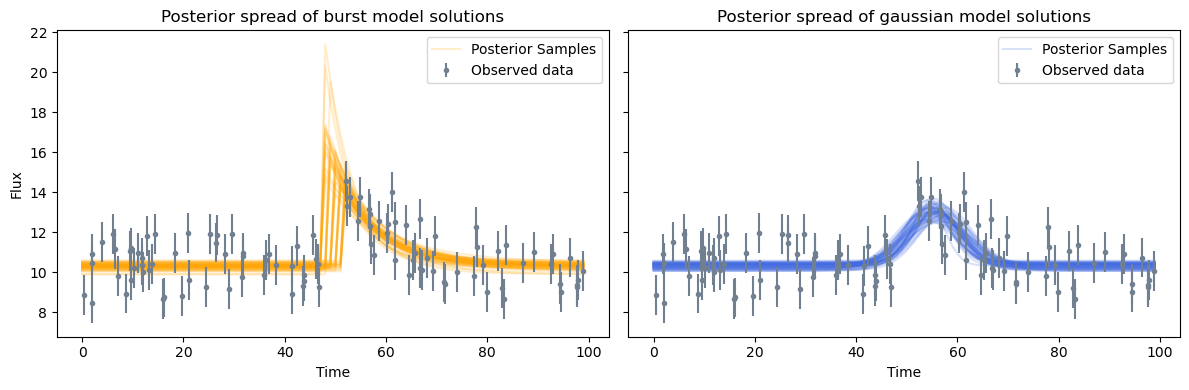

In [21]:
index = np.random.choice(len(gauss_samples), size=50, replace=False)
gauss_par = gauss_samples[index]

index = np.random.choice(len(burst_samples), size=50, replace=False)
burst_par = burst_samples[index]


fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True, layout='tight')

models = [burst_model, gauss_model]
random_par = [burst_par, gauss_par]
title = ['burst', 'gaussian']
color = ['orange', 'royalblue']

for i, ax in enumerate(axs):
    for j, par in enumerate(random_par[i]):
        y = models[i](par, t)
        l = "Posterior Samples" if j == 0 else None
        ax.plot(t, y, color=color[i], alpha=.2, label=l)
        
    ax.errorbar(time, flux, errf, fmt='.', c='slategray', label='Observed data')

    ax.set_title('Posterior spread of ' + title[i] + ' model solutions')
    ax.set_xlabel('Time')

    ax.legend()

axs[0].set_ylabel('Flux');

In [22]:
B_12 = np.exp(logZ_burst) / np.exp(logZ_gauss)
print('Bayesian factor: ', B_12, '\n')

# Interpretazione secondo la Jeffreys' scale
def interpret_bayes_factor(B):
    if 0 <= B < 1/2:
        return "Barely worth mentioning for Model 1"
    elif 1/2 <= B < 1:
        return "Substantial evidence for Model 1"
    elif 1 <= B < 3/2:
        return "Strong evidence for Model 1"
    elif 3/2 <= B < 2:
        return "Very strong evidence for Model 1"
    elif 2 <= B:
        return "Decisive evidence for Model 1"


print('Interpretation according to Jeffreys\' scale: ', interpret_bayes_factor(np.log10(B_12)), '(aka burst model)')

Bayesian factor:  179.04598100106406 

Interpretation according to Jeffreys' scale:  Decisive evidence for Model 1 (aka burst model)
